In [1]:
import numpy as np
import os, sys
from skimage import io
import matplotlib
from pprint import pprint
from matplotlib import pyplot as plt
from tqdm import tqdm
import cv2
import pickle

In [2]:
HOME = os.path.expanduser("~")
PATH = os.path.join(HOME, 'programming/pipeline_utility/src')
sys.path.append(PATH)
from lib.FileLocationManager import DATA_PATH, ROOT_DIR
from lib.utilities_atlas import  singular_structures, average_shape

In [3]:
from lib.sqlcontroller import SqlController
from lib.file_location import FileLocationManager
from lib.utilities_process import SCALING_FACTOR
POLYGON_ID = 54
structure_dict = sqlController.get_structures_dict()

In [4]:
atlas_name = 'atlasV8'
ATLAS_PATH = os.path.join(DATA_PATH, 'atlas_data', atlas_name)

In [5]:
structure = 'SC'
structure_info = structure_dict[structure]
color = structure_info[1]
desc = structure_info[0]
FK_structure_id = structure_info[2]

volume_origin_list = []
brains = ['MD589', 'MD594', 'MD585']
for brain in brains:
    origin_path = os.path.join(ATLAS_PATH, brain, 'origin')
    volume_path = os.path.join(ATLAS_PATH, brain, 'structure')
    ofilepath = os.path.join(origin_path, f'{structure}.txt')
    vfilepath = os.path.join(volume_path, f'{structure}.npy')
    origin = np.loadtxt(ofilepath)
    volume = np.load(vfilepath)
    volume = volume * color
    volume = volume.astype(np.uint8)
    volume_origin_list.append((volume, origin))
    print(brain, origin, volume.shape, volume.dtype, np.amin(volume), np.amax(volume), np.mean(volume))

MD589 [698.4371304  278.44020778 128.        ] (162, 109, 182) uint8 0 18 5.1375138622845045
MD594 [710.71094924 205.46951053 137.        ] (139, 140, 169) uint8 0 18 5.055154253604724
MD585 [643.08986006 178.83826474 136.        ] (151, 127, 181) uint8 0 18 5.0035473548683


In [21]:
volume_origin_list = []

for brain in brains:
    sqlController = SqlController(brain)
    brain_shape = sqlController.get_brain_shape(brain, FK_structure_id, False)
    scale_xy = sqlController.scan_run.resolution
    z_scale = sqlController.scan_run.zresolution

    x = int(round((brain_shape.xoffset/scale_xy)*SCALING_FACTOR))
    y = int(round((brain_shape.yoffset/scale_xy)*SCALING_FACTOR))
    z = int(round(brain_shape.zoffset/z_scale))
    origin = (x,y,z)
    volume = pickle.loads(brain_shape.numpy_data)
    volume = volume * color
    volume_origin_list.append((volume, origin))
    print(brain, origin, volume.shape, volume.dtype, np.amin(volume), np.amax(volume), np.mean(volume))


MD589 (698, 279, 128) (104, 158, 183) uint8 0 18 5.4503906811180105
MD594 (710, 205, 137) (135, 135, 172) uint8 0 18 5.256227390180879
MD585 (643, 179, 136) (205, 146, 183) uint8 0 18 3.145210956713205


In [12]:
sigma = 5.
volume, origin = average_shape(volume_origin_list=volume_origin_list, force_symmetric=True, sigma=sigma)

In [22]:
volume = np.swapaxes(volume, 0,1)
print(origin, volume.shape, volume.dtype, np.amin(volume), np.amax(volume), np.mean(volume))

(643, 179, 136) (146, 205, 183) uint8 0 18 3.145210956713205


In [ ]:
sc7path = '/net/birdstore/Active_Atlas_Data/data_root/atlas_data/atlasV7/structure/SC.npy'
sc7 = np.load(sc7path)
print(sc7.shape, sc7.dtype, np.amin(sc7), np.amax(sc7), np.mean(sc7))
sc8path = '/net/birdstore/Active_Atlas_Data/data_root/atlas_data/atlasV8/structure/SC.npy'
sc8 = np.load(sc8path)
print(sc8.shape, sc8.dtype, np.amin(sc8), np.amax(sc8), np.mean(sc8))

In [28]:
#volume = volume.reshape(volume.shape[0], volume.shape[1], volume.shape[2])
arr = volume.copy()
#arr[arr > 0] = color
#arr = arr.astype(np.uint8)
print('volume shape', arr.shape, arr.dtype, np.unique(arr, return_counts=False))

volume shape (146, 205, 183) uint8 [ 0 18]


Text(0.5, 1.0, ' uint8')

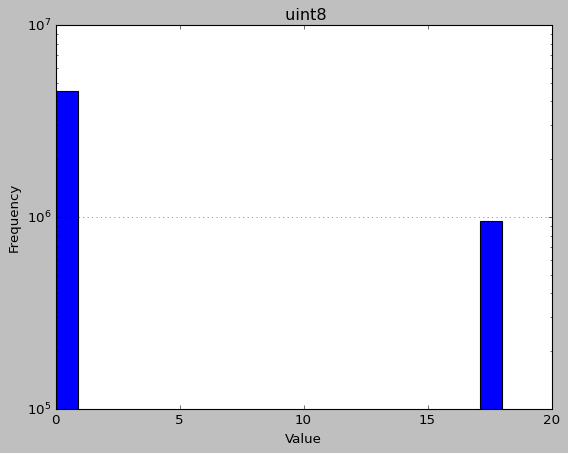

In [24]:
flat = arr.flatten()
fig = plt.figure()
plt.rcParams['figure.figsize'] = [10, 6]
plt.hist(flat, bins=20, color='b')
plt.style.use('ggplot')
plt.yscale('log')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title(f' {arr.dtype}')

(146, 205, 183)


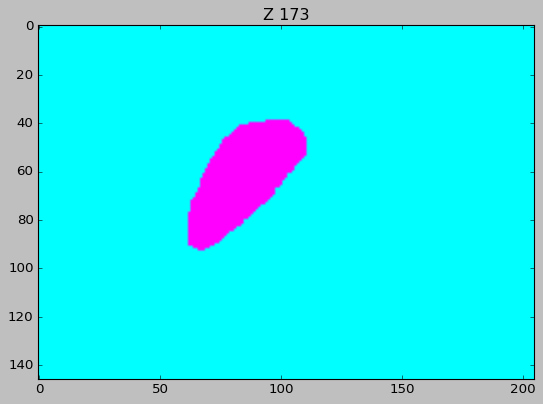

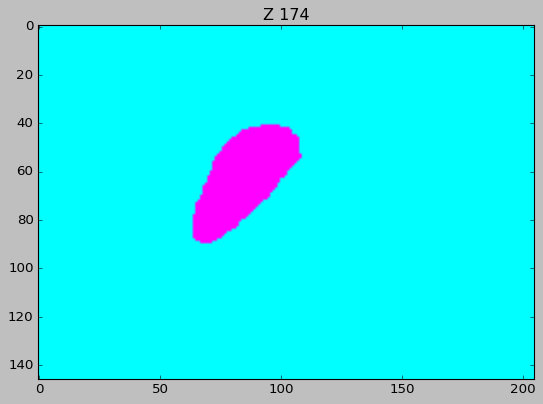

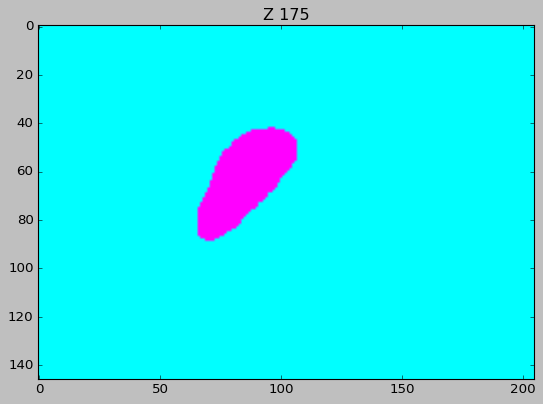

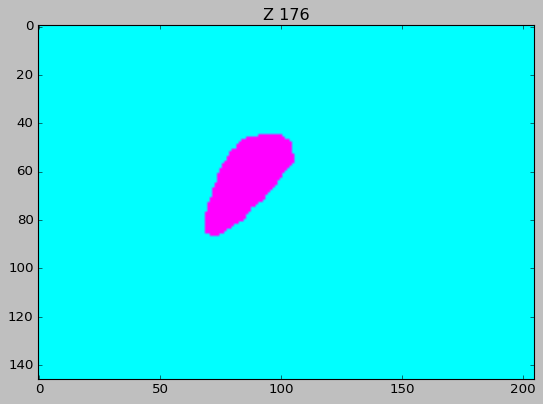

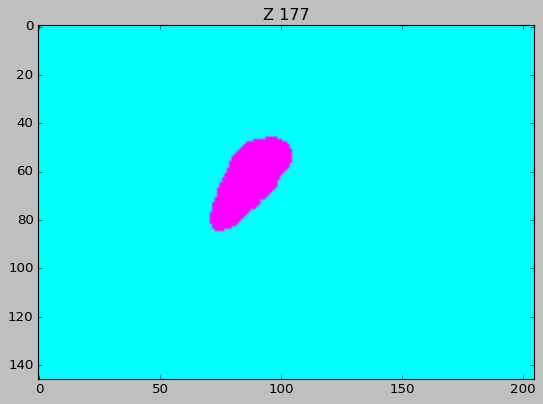

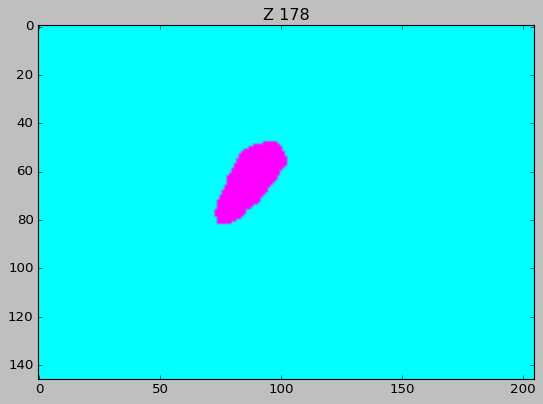

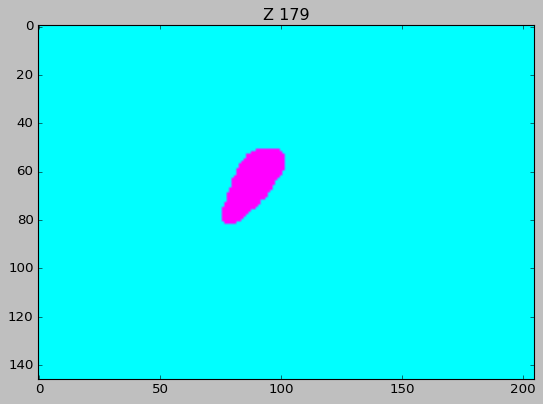

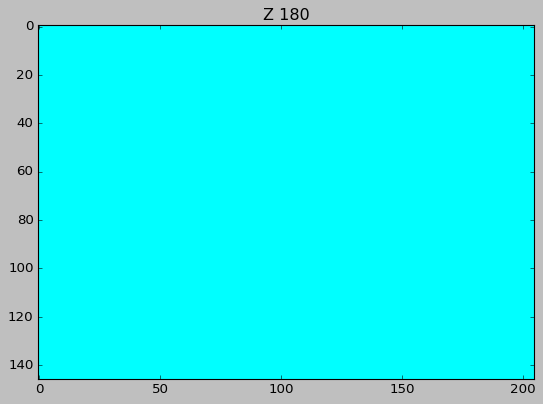

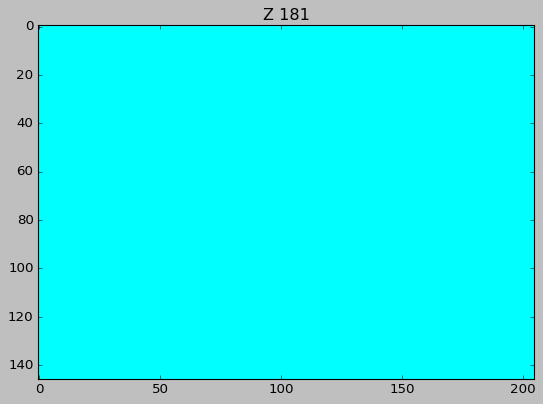

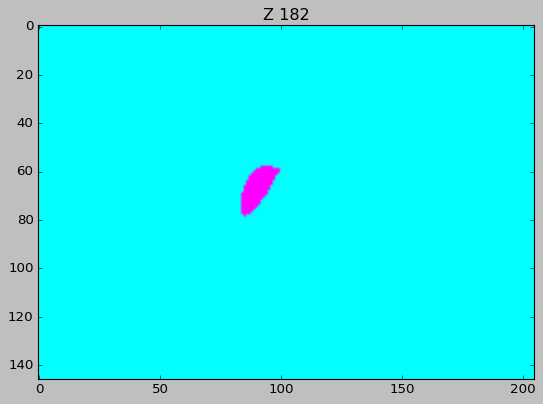

In [25]:
#arr = sc.copy()
#arr = np.rot90(volume, axes=(2, 1))
#arr = np.rot90(arr, 3)
#arr = np.flip(arr, axis=1)    
print(arr.shape)
start = arr.shape[2] - 10
end = start + 10
plt.style.use('classic')
for i in range(start, end,1):
    plt.title('Z {}'.format(i))
    plt.imshow(arr[:,:,i], cmap="cool")
    plt.show()

In [29]:
from scipy.ndimage import affine_transform

angle=10/180*np.pi
c=np.cos(angle)
s=np.sin(angle)
mat = np.array([[c,-s,0,0],[s,c,0,0],[0,0,1,0],[0,0,0,1]])
out3 = affine_transform(arr,mat)
print("out3: ",out3.shape)

out3:  (146, 205, 183)
